# Outcome Prediction (Node Classification) with TransE Model + MLP

In [18]:
import joblib

import pandas as pd

from pykeen.triples import TriplesFactory
from pykeen.pipeline import pipeline

## 1. Get embeddings for each patient using TransE model

In [19]:
num_patients = 1000
path = 'processed_data'
tf = TriplesFactory.from_path(f'{path}/sphn_events_{num_patients}_noOutcome.tsv', create_inverse_triples=True)
print(tf)

TriplesFactory(num_entities=33563, num_relations=20, create_inverse_triples=True, num_triples=110935, path="/home/baical77/projects/neurovasc/notebooks/Graphs/processed_data/sphn_events_1000_noOutcome.tsv")


No random seed is specified. Setting to 1260501498.
INFO:pykeen.triples.triples_factory:Creating inverse triples.


Training epochs on cuda:0:   0%|          | 0/10 [00:00<?, ?epoch/s]

INFO:pykeen.triples.triples_factory:Creating inverse triples.


Evaluating on cuda:0:   0%|          | 0.00/111k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 524.78s seconds


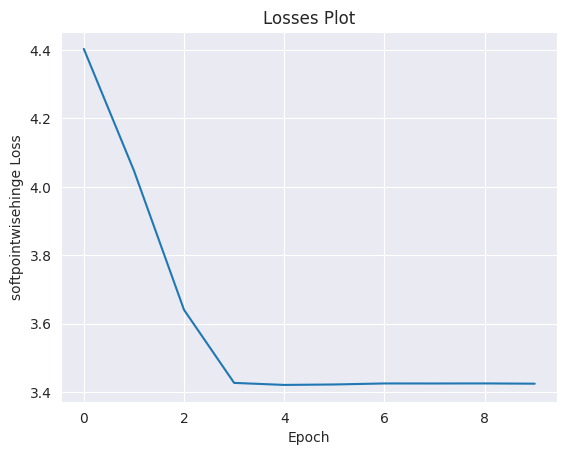

In [20]:
model_name = 'TransE'
embedding_dim = 100
epochs = 10

result = pipeline(
    training=tf,
    testing=tf,
    model=model_name,
    model_kwargs=dict(
        embedding_dim=embedding_dim,
        loss="softPointwiseHingeLoss",
    ),
    training_kwargs=dict(
        num_epochs=epochs,
        # label_smoothing=0.1,
        use_tqdm_batch=False,
    ),
    optimizer_kwargs=dict(
        lr=0.01,
        weight_decay=1e-5,
    ),
    training_loop='sLCWA',
    negative_sampler='basic',
    device='gpu',
    use_tqdm=True,
)

#plot loss
loss_plot = result.plot_losses()

## 2. Train the NN model to predict outcomes (node classification)

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F


entity = pd.read_csv(f'processed_data/sphn_entities_{num_patients}_noOutcome.tsv', sep='\t', index_col=0, header=None)
entity = entity.to_dict()[1]
patient_id = []
for i in range(num_patients):
    idx = f'<http://nvasc.org/synth_patient_{i}>'
    patient_id.append(entity[idx])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = result.model
entity_embedding = model.entity_representations[0](indices=None).detach().cpu()
patient_embedding = entity_embedding[patient_id]
print(f'Patient embedding size: {patient_embedding.shape}')

patient_embedding = patient_embedding.to(device)
y = joblib.load(f'../Data Generation/outcomes_{num_patients}_0.joblib')
y = torch.Tensor(y).long().to(device)

train_x, train_y = patient_embedding[:int(num_patients*0.8)], y[:int(num_patients*0.8)]
val_x, val_y = patient_embedding[int(num_patients*0.8):int(num_patients*0.9)], y[int(num_patients*0.8):int(num_patients*0.9)]
test_x, test_y = patient_embedding[int(num_patients*0.9):], y[int(num_patients*0.9):]

Patient embedding size: torch.Size([1000, 100])


In [23]:
# MLP classifier
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(100, 32),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(32, 32),
            nn.ReLU(),
            # nn.Dropout(p=0.2),
            nn.Linear(32, 3),
        )

    def forward(self, x):
        x = self.linear_relu_stack(x)
        return F.log_softmax(x, dim=1)
    
model = NeuralNetwork().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5)


def train():
    model.train()
    optimizer.zero_grad()
    out = model(train_x)
    loss = F.nll_loss(out, train_y)
    loss.backward()
    optimizer.step()
    return float(loss)

@torch.no_grad()
def test():
    model.eval()
    pred = model(patient_embedding).argmax(dim=-1)
    train_acc = float((pred[:int(num_patients*0.8)] == train_y).float().mean())
    val_acc = float((pred[int(num_patients*0.8):int(num_patients*0.9)] == val_y).float().mean())
    test_acc = float((pred[int(num_patients*0.9):] == test_y).float().mean())
    return train_acc, val_acc, test_acc

import time

times = []
best_acc = float(0.)

for epoch in range(1, 1001):
    start = time.time()
    loss = train()
    train_acc, val_acc, test_acc = test()
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f} | Train: {train_acc:.4f}, Val: {val_acc:.4f}, '
        f'Test: {test_acc:.4f}')
    times.append(time.time() - start)
print(f"Median time per epoch: {torch.tensor(times).median():.4f}s")

Epoch: 01, Loss: 1.1089 | Train: 0.4512, Val: 0.4500, Test: 0.5000
Epoch: 02, Loss: 1.0843 | Train: 0.4512, Val: 0.4500, Test: 0.5000
Epoch: 03, Loss: 1.0593 | Train: 0.4512, Val: 0.4500, Test: 0.5000
Epoch: 04, Loss: 1.0319 | Train: 0.4500, Val: 0.4500, Test: 0.4900
Epoch: 05, Loss: 1.0037 | Train: 0.4375, Val: 0.4800, Test: 0.4600
Epoch: 06, Loss: 0.9805 | Train: 0.4375, Val: 0.4800, Test: 0.4100
Epoch: 07, Loss: 0.9707 | Train: 0.4375, Val: 0.4700, Test: 0.4000
Epoch: 08, Loss: 0.9771 | Train: 0.4525, Val: 0.4500, Test: 0.4900
Epoch: 09, Loss: 0.9873 | Train: 0.4512, Val: 0.4500, Test: 0.5000
Epoch: 10, Loss: 0.9924 | Train: 0.4512, Val: 0.4500, Test: 0.5000
Epoch: 11, Loss: 0.9810 | Train: 0.4512, Val: 0.4500, Test: 0.5000
Epoch: 12, Loss: 0.9719 | Train: 0.4650, Val: 0.4500, Test: 0.4400
Epoch: 13, Loss: 0.9644 | Train: 0.4700, Val: 0.4800, Test: 0.4200
Epoch: 14, Loss: 0.9614 | Train: 0.4688, Val: 0.4900, Test: 0.4000
Epoch: 15, Loss: 0.9582 | Train: 0.4762, Val: 0.4800, Test: 0.

## 3. Results - AUC / Confusion Matrix

In [24]:
from sklearn.metrics import roc_auc_score

model.eval()
with torch.no_grad():
    out = model(patient_embedding).cpu()
    prob = F.softmax(out, dim=1)
auc = roc_auc_score(test_y.cpu(), prob[int(num_patients*0.9):], multi_class='ovr')
print(f'ROC AUC score: {auc:.4f}')

ROC AUC score: 0.5214


0
0    50
1    37
2    13
Name: count, dtype: int64


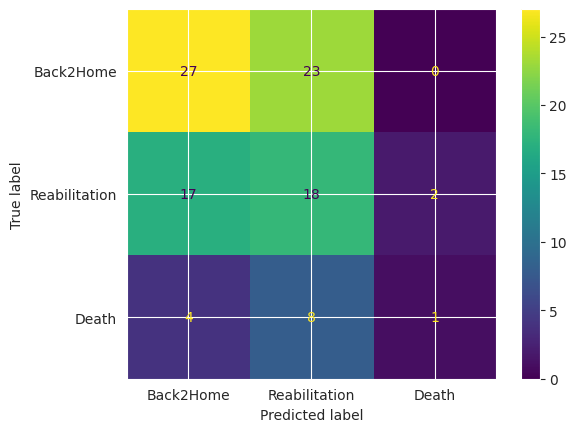

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

print(pd.DataFrame(test_y.cpu()).value_counts())

model.eval()
pred = model(patient_embedding).argmax(dim=-1)
matrix = confusion_matrix(test_y.cpu(), pred[int(num_patients*0.9):].cpu())
disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=["Back2Home", "Reabilitation", "Death"])
disp.plot()
plt.show()